# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'
()

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

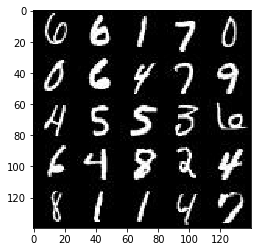

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

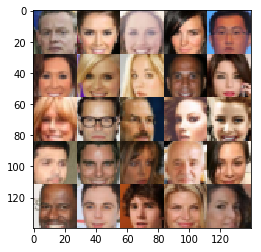

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputReal = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name = "inputReal")
    inputZ = tf.placeholder(tf.float32, shape=[None, z_dim], name = 'inputZ')
    learningRate = tf.placeholder(tf.float32, name = 'learningRate')
    
    return inputReal,    inputZ,    learningRate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start\n    handler_func(fd_obj, events)', 'File "/opt/conda/lib/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
# def discriminator(images, reuse=False):
def discriminator(x, reuse=False, alpha=0.2):
    images = x
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
    
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
# def generator(z, out_channel_dim, is_train=True):
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    output_dim = out_channel_dim
#     training = is_train 
    
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
#         8x8x256 now
        
        x2 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
#         8x8x256 now
        
#         x2 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding='same')
#         x2 = tf.layers.batch_normalization(x2, training=is_train)
#         x2 = tf.maximum(alpha * x2, x2)
#         8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, output_dim, 3, strides=1, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
        return out
    
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
# def model_loss(input_real, input_z, out_channel_dim):
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    out_channel_dim = output_dim
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=0.9*tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    
    # data shape
    _, image_width, image_height, image_channels = data_shape

    # use predefined functions
    input_real, input_z, learningRate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learningRate : learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learningRate : learning_rate})
#                 _ = sess.run(g_train_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
#                     # Save losses to view after training
#                     losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
#                     gen_samples = sess.run(
#                                    generator(net.input_z, 3, reuse=True, training=False),
#                                    feed_dict={net.input_z: sample_z})
#                     samples.append(gen_samples)
#                     _ = view_samples(-1, samples, 6, 12, figsize=figsize)
#                     plt.show()

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4205... Generator Loss: 2.8741
Epoch 1/2... Discriminator Loss: 0.4054... Generator Loss: 2.7136
Epoch 1/2... Discriminator Loss: 0.5995... Generator Loss: 1.6792
Epoch 1/2... Discriminator Loss: 4.0739... Generator Loss: 0.0356
Epoch 1/2... Discriminator Loss: 3.8407... Generator Loss: 0.0415


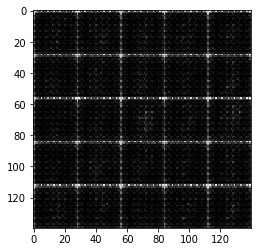

Epoch 1/2... Discriminator Loss: 2.5217... Generator Loss: 0.1572
Epoch 1/2... Discriminator Loss: 1.2909... Generator Loss: 1.1207
Epoch 1/2... Discriminator Loss: 1.6932... Generator Loss: 1.6222
Epoch 1/2... Discriminator Loss: 1.8909... Generator Loss: 0.2753
Epoch 1/2... Discriminator Loss: 0.8697... Generator Loss: 1.7148


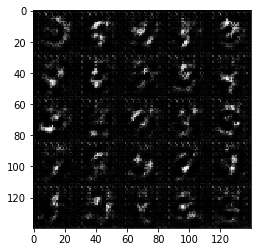

Epoch 1/2... Discriminator Loss: 0.7163... Generator Loss: 1.8986
Epoch 1/2... Discriminator Loss: 1.8287... Generator Loss: 0.3229
Epoch 1/2... Discriminator Loss: 0.5143... Generator Loss: 2.0291
Epoch 1/2... Discriminator Loss: 1.2307... Generator Loss: 0.6104
Epoch 1/2... Discriminator Loss: 0.7762... Generator Loss: 1.1666


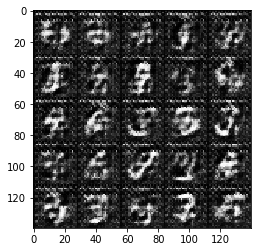

Epoch 1/2... Discriminator Loss: 0.4726... Generator Loss: 2.2543
Epoch 1/2... Discriminator Loss: 2.5828... Generator Loss: 0.1330
Epoch 1/2... Discriminator Loss: 3.2536... Generator Loss: 0.0707
Epoch 1/2... Discriminator Loss: 0.7970... Generator Loss: 1.1417
Epoch 1/2... Discriminator Loss: 1.8956... Generator Loss: 1.9537


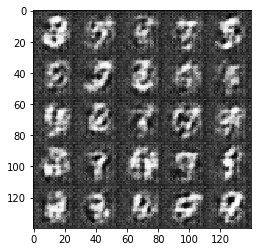

Epoch 1/2... Discriminator Loss: 1.6253... Generator Loss: 0.3676
Epoch 1/2... Discriminator Loss: 0.4881... Generator Loss: 2.7333
Epoch 1/2... Discriminator Loss: 1.0647... Generator Loss: 0.6935
Epoch 1/2... Discriminator Loss: 1.2404... Generator Loss: 3.3366
Epoch 1/2... Discriminator Loss: 0.4425... Generator Loss: 2.5631


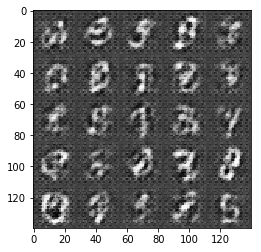

Epoch 1/2... Discriminator Loss: 0.7463... Generator Loss: 4.1593
Epoch 1/2... Discriminator Loss: 0.6628... Generator Loss: 2.9386
Epoch 1/2... Discriminator Loss: 0.3710... Generator Loss: 3.9836
Epoch 1/2... Discriminator Loss: 2.0961... Generator Loss: 0.2087
Epoch 1/2... Discriminator Loss: 0.8912... Generator Loss: 0.9085


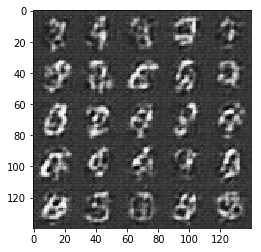

Epoch 1/2... Discriminator Loss: 1.2079... Generator Loss: 3.3393
Epoch 1/2... Discriminator Loss: 0.7344... Generator Loss: 2.3593
Epoch 1/2... Discriminator Loss: 0.7758... Generator Loss: 2.7131
Epoch 1/2... Discriminator Loss: 0.9769... Generator Loss: 0.9140
Epoch 1/2... Discriminator Loss: 1.5491... Generator Loss: 0.4644


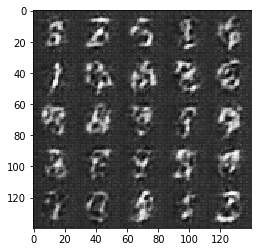

Epoch 1/2... Discriminator Loss: 0.5516... Generator Loss: 3.7974
Epoch 1/2... Discriminator Loss: 0.3918... Generator Loss: 4.3040
Epoch 1/2... Discriminator Loss: 2.8367... Generator Loss: 0.1311
Epoch 1/2... Discriminator Loss: 0.5542... Generator Loss: 1.7807
Epoch 1/2... Discriminator Loss: 0.5717... Generator Loss: 3.4663


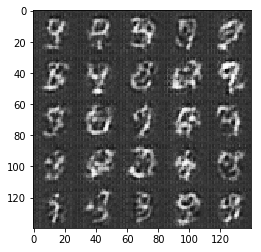

Epoch 1/2... Discriminator Loss: 0.5025... Generator Loss: 2.0158
Epoch 1/2... Discriminator Loss: 3.1535... Generator Loss: 0.0793
Epoch 1/2... Discriminator Loss: 0.8421... Generator Loss: 1.0830
Epoch 1/2... Discriminator Loss: 0.5114... Generator Loss: 1.9830
Epoch 1/2... Discriminator Loss: 0.3705... Generator Loss: 3.3748


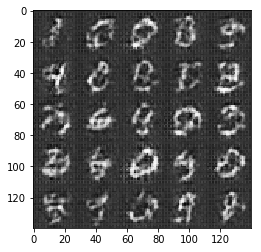

Epoch 1/2... Discriminator Loss: 0.3706... Generator Loss: 3.3850
Epoch 1/2... Discriminator Loss: 0.9228... Generator Loss: 0.9531
Epoch 1/2... Discriminator Loss: 0.5650... Generator Loss: 1.6713
Epoch 1/2... Discriminator Loss: 0.3948... Generator Loss: 2.9858
Epoch 1/2... Discriminator Loss: 0.4474... Generator Loss: 2.5196


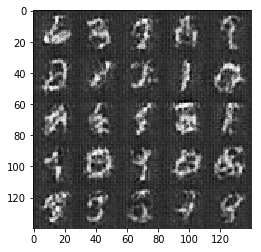

Epoch 1/2... Discriminator Loss: 0.7613... Generator Loss: 1.2488
Epoch 1/2... Discriminator Loss: 0.4278... Generator Loss: 2.6930
Epoch 1/2... Discriminator Loss: 0.8467... Generator Loss: 4.6126
Epoch 1/2... Discriminator Loss: 0.7015... Generator Loss: 1.3427
Epoch 1/2... Discriminator Loss: 0.4086... Generator Loss: 4.0386


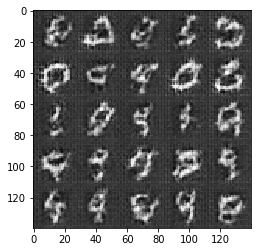

Epoch 1/2... Discriminator Loss: 0.3580... Generator Loss: 3.9615
Epoch 1/2... Discriminator Loss: 0.3366... Generator Loss: 5.0803
Epoch 1/2... Discriminator Loss: 0.3950... Generator Loss: 3.4924
Epoch 1/2... Discriminator Loss: 0.4053... Generator Loss: 3.6257
Epoch 1/2... Discriminator Loss: 0.3548... Generator Loss: 6.6920


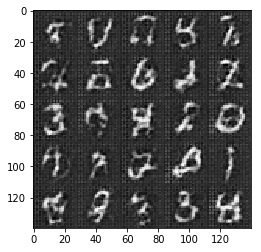

Epoch 1/2... Discriminator Loss: 0.3782... Generator Loss: 3.3203
Epoch 1/2... Discriminator Loss: 1.6465... Generator Loss: 1.4863
Epoch 1/2... Discriminator Loss: 0.9058... Generator Loss: 1.4961
Epoch 1/2... Discriminator Loss: 0.8371... Generator Loss: 1.0306
Epoch 1/2... Discriminator Loss: 0.3515... Generator Loss: 4.2021


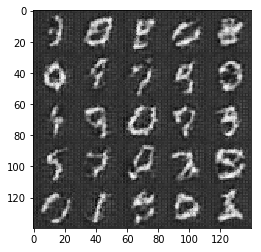

Epoch 1/2... Discriminator Loss: 1.0513... Generator Loss: 0.9672
Epoch 1/2... Discriminator Loss: 0.6912... Generator Loss: 1.3599
Epoch 1/2... Discriminator Loss: 0.8400... Generator Loss: 1.2319
Epoch 1/2... Discriminator Loss: 0.4250... Generator Loss: 2.9839
Epoch 1/2... Discriminator Loss: 0.4121... Generator Loss: 5.7078


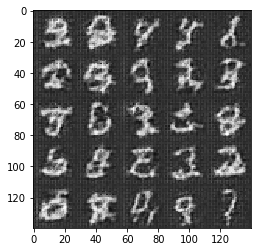

Epoch 1/2... Discriminator Loss: 0.9258... Generator Loss: 0.9564
Epoch 1/2... Discriminator Loss: 1.2336... Generator Loss: 1.1440
Epoch 1/2... Discriminator Loss: 0.4287... Generator Loss: 2.6925
Epoch 1/2... Discriminator Loss: 0.3700... Generator Loss: 4.1524
Epoch 1/2... Discriminator Loss: 0.3514... Generator Loss: 4.2073


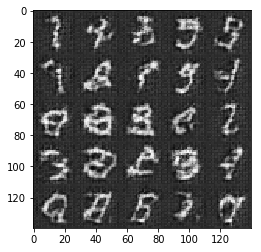

Epoch 1/2... Discriminator Loss: 0.3644... Generator Loss: 3.9756
Epoch 1/2... Discriminator Loss: 0.5294... Generator Loss: 2.0207
Epoch 1/2... Discriminator Loss: 0.3527... Generator Loss: 4.1167
Epoch 1/2... Discriminator Loss: 0.8841... Generator Loss: 0.9699
Epoch 1/2... Discriminator Loss: 0.9430... Generator Loss: 2.2151


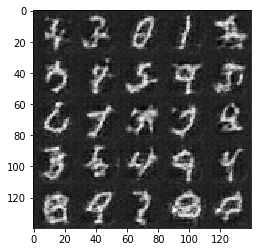

Epoch 1/2... Discriminator Loss: 0.8265... Generator Loss: 1.1086
Epoch 1/2... Discriminator Loss: 0.7648... Generator Loss: 1.4671
Epoch 1/2... Discriminator Loss: 0.3489... Generator Loss: 5.2169
Epoch 1/2... Discriminator Loss: 0.3855... Generator Loss: 5.5280
Epoch 1/2... Discriminator Loss: 0.4651... Generator Loss: 2.2874


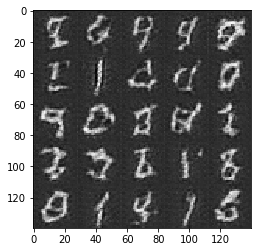

Epoch 1/2... Discriminator Loss: 0.5310... Generator Loss: 2.1217
Epoch 1/2... Discriminator Loss: 2.4851... Generator Loss: 0.1750
Epoch 1/2... Discriminator Loss: 0.8976... Generator Loss: 1.3990
Epoch 1/2... Discriminator Loss: 0.4017... Generator Loss: 2.9740
Epoch 1/2... Discriminator Loss: 0.9747... Generator Loss: 0.7896


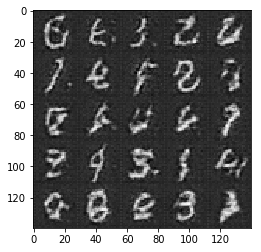

Epoch 1/2... Discriminator Loss: 1.0331... Generator Loss: 1.2272
Epoch 1/2... Discriminator Loss: 1.1253... Generator Loss: 0.6507
Epoch 1/2... Discriminator Loss: 0.5360... Generator Loss: 1.9701
Epoch 1/2... Discriminator Loss: 1.7170... Generator Loss: 0.4160
Epoch 1/2... Discriminator Loss: 0.8272... Generator Loss: 1.0449


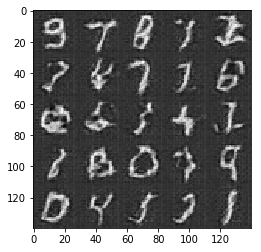

Epoch 1/2... Discriminator Loss: 0.4743... Generator Loss: 2.2720
Epoch 1/2... Discriminator Loss: 1.1527... Generator Loss: 0.7626
Epoch 1/2... Discriminator Loss: 0.6564... Generator Loss: 1.3699
Epoch 1/2... Discriminator Loss: 0.8430... Generator Loss: 1.0900
Epoch 1/2... Discriminator Loss: 0.3738... Generator Loss: 3.8582


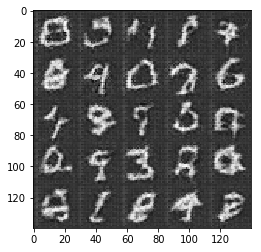

Epoch 1/2... Discriminator Loss: 0.3308... Generator Loss: 6.4950
Epoch 1/2... Discriminator Loss: 0.7817... Generator Loss: 2.9283
Epoch 1/2... Discriminator Loss: 0.4367... Generator Loss: 2.4906
Epoch 1/2... Discriminator Loss: 0.7016... Generator Loss: 1.2996
Epoch 1/2... Discriminator Loss: 0.3539... Generator Loss: 4.3869


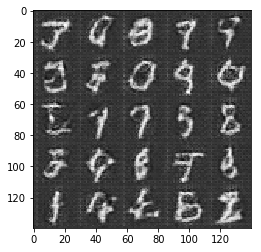

Epoch 1/2... Discriminator Loss: 0.3925... Generator Loss: 3.8518
Epoch 1/2... Discriminator Loss: 0.5978... Generator Loss: 1.5851
Epoch 1/2... Discriminator Loss: 0.6823... Generator Loss: 1.3872
Epoch 1/2... Discriminator Loss: 0.3379... Generator Loss: 5.1033
Epoch 1/2... Discriminator Loss: 0.4116... Generator Loss: 2.6574


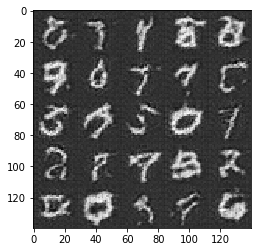

Epoch 1/2... Discriminator Loss: 2.2022... Generator Loss: 0.3149
Epoch 1/2... Discriminator Loss: 0.9665... Generator Loss: 0.9067
Epoch 1/2... Discriminator Loss: 0.6772... Generator Loss: 1.3711
Epoch 1/2... Discriminator Loss: 0.4117... Generator Loss: 3.6780
Epoch 1/2... Discriminator Loss: 0.3409... Generator Loss: 6.0868


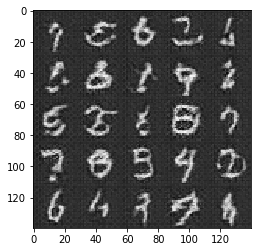

Epoch 1/2... Discriminator Loss: 0.4130... Generator Loss: 4.4241
Epoch 1/2... Discriminator Loss: 1.0586... Generator Loss: 0.7912
Epoch 1/2... Discriminator Loss: 1.7140... Generator Loss: 0.3950
Epoch 1/2... Discriminator Loss: 0.9005... Generator Loss: 1.1257
Epoch 1/2... Discriminator Loss: 0.5835... Generator Loss: 1.8301


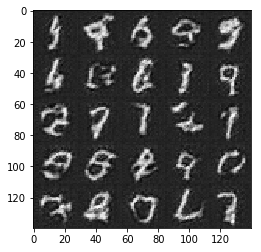

Epoch 1/2... Discriminator Loss: 1.1353... Generator Loss: 0.6837
Epoch 1/2... Discriminator Loss: 0.3835... Generator Loss: 3.7393
Epoch 1/2... Discriminator Loss: 1.7830... Generator Loss: 0.3085
Epoch 1/2... Discriminator Loss: 0.8042... Generator Loss: 1.1641
Epoch 1/2... Discriminator Loss: 0.7881... Generator Loss: 1.1370


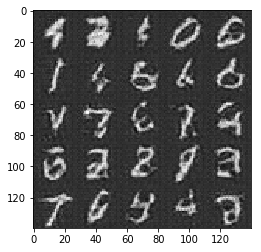

Epoch 1/2... Discriminator Loss: 0.7380... Generator Loss: 1.6285
Epoch 1/2... Discriminator Loss: 0.3532... Generator Loss: 3.9917
Epoch 1/2... Discriminator Loss: 0.6696... Generator Loss: 1.3793
Epoch 1/2... Discriminator Loss: 0.4417... Generator Loss: 2.3807
Epoch 1/2... Discriminator Loss: 0.3994... Generator Loss: 3.3617


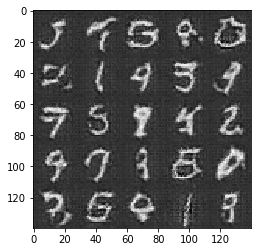

Epoch 1/2... Discriminator Loss: 0.6588... Generator Loss: 1.3803
Epoch 1/2... Discriminator Loss: 0.3468... Generator Loss: 5.8291
Epoch 1/2... Discriminator Loss: 0.3339... Generator Loss: 6.8410
Epoch 1/2... Discriminator Loss: 0.3310... Generator Loss: 6.0206
Epoch 1/2... Discriminator Loss: 0.6995... Generator Loss: 1.3153


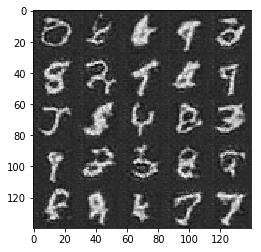

Epoch 1/2... Discriminator Loss: 0.7209... Generator Loss: 2.3665
Epoch 1/2... Discriminator Loss: 1.2273... Generator Loss: 0.6136
Epoch 1/2... Discriminator Loss: 2.1460... Generator Loss: 0.2525
Epoch 1/2... Discriminator Loss: 0.4294... Generator Loss: 2.6862
Epoch 1/2... Discriminator Loss: 0.9053... Generator Loss: 0.9393


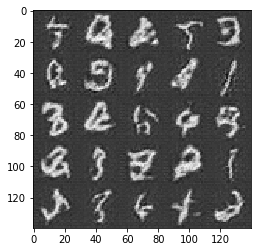

Epoch 1/2... Discriminator Loss: 0.3514... Generator Loss: 5.8593
Epoch 1/2... Discriminator Loss: 0.8592... Generator Loss: 1.3638
Epoch 1/2... Discriminator Loss: 0.8342... Generator Loss: 1.0546
Epoch 1/2... Discriminator Loss: 0.6146... Generator Loss: 3.2792
Epoch 1/2... Discriminator Loss: 2.4062... Generator Loss: 0.2417


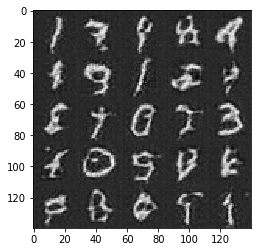

Epoch 1/2... Discriminator Loss: 0.3526... Generator Loss: 4.4896
Epoch 1/2... Discriminator Loss: 0.5817... Generator Loss: 2.3248
Epoch 1/2... Discriminator Loss: 0.3693... Generator Loss: 5.0966
Epoch 1/2... Discriminator Loss: 0.8712... Generator Loss: 1.2188
Epoch 1/2... Discriminator Loss: 0.8985... Generator Loss: 1.4040


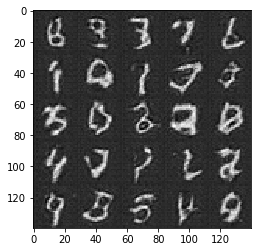

Epoch 1/2... Discriminator Loss: 0.9789... Generator Loss: 0.8482
Epoch 1/2... Discriminator Loss: 0.8017... Generator Loss: 1.5106
Epoch 1/2... Discriminator Loss: 1.0894... Generator Loss: 0.7892
Epoch 1/2... Discriminator Loss: 0.3751... Generator Loss: 3.5462
Epoch 1/2... Discriminator Loss: 0.5735... Generator Loss: 1.7416


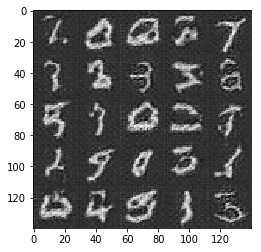

Epoch 1/2... Discriminator Loss: 0.3971... Generator Loss: 4.4232
Epoch 1/2... Discriminator Loss: 0.3316... Generator Loss: 6.1411
Epoch 1/2... Discriminator Loss: 0.3393... Generator Loss: 4.9002
Epoch 1/2... Discriminator Loss: 0.7132... Generator Loss: 1.3209
Epoch 1/2... Discriminator Loss: 0.4297... Generator Loss: 2.8898


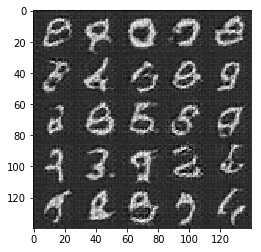

Epoch 1/2... Discriminator Loss: 0.4734... Generator Loss: 2.2287
Epoch 1/2... Discriminator Loss: 1.7385... Generator Loss: 0.3738
Epoch 1/2... Discriminator Loss: 1.1714... Generator Loss: 0.6559
Epoch 1/2... Discriminator Loss: 1.7381... Generator Loss: 0.4263
Epoch 1/2... Discriminator Loss: 0.4739... Generator Loss: 3.7868


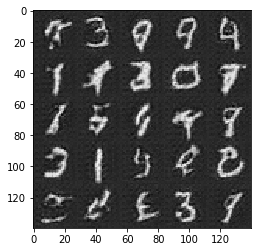

Epoch 1/2... Discriminator Loss: 0.7625... Generator Loss: 1.1217
Epoch 1/2... Discriminator Loss: 0.3562... Generator Loss: 3.8640
Epoch 1/2... Discriminator Loss: 1.9090... Generator Loss: 0.3207
Epoch 1/2... Discriminator Loss: 0.6359... Generator Loss: 1.6218
Epoch 1/2... Discriminator Loss: 0.3810... Generator Loss: 4.5917


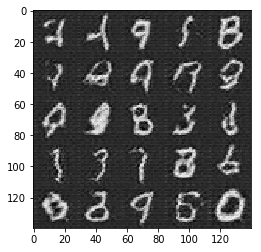

Epoch 1/2... Discriminator Loss: 1.6746... Generator Loss: 0.4362
Epoch 1/2... Discriminator Loss: 1.0731... Generator Loss: 0.7675
Epoch 1/2... Discriminator Loss: 0.5140... Generator Loss: 2.0292
Epoch 1/2... Discriminator Loss: 0.3522... Generator Loss: 4.4363
Epoch 1/2... Discriminator Loss: 0.9350... Generator Loss: 2.2872


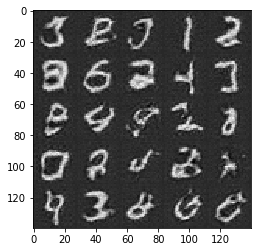

Epoch 1/2... Discriminator Loss: 0.3390... Generator Loss: 5.4375
Epoch 1/2... Discriminator Loss: 0.3528... Generator Loss: 6.0374
Epoch 1/2... Discriminator Loss: 0.3374... Generator Loss: 5.0981
Epoch 1/2... Discriminator Loss: 0.6164... Generator Loss: 4.8886
Epoch 1/2... Discriminator Loss: 0.6156... Generator Loss: 2.0647


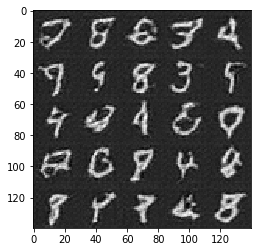

Epoch 1/2... Discriminator Loss: 0.8712... Generator Loss: 1.1727
Epoch 1/2... Discriminator Loss: 0.5970... Generator Loss: 1.8075
Epoch 1/2... Discriminator Loss: 0.3829... Generator Loss: 3.2846
Epoch 1/2... Discriminator Loss: 2.7332... Generator Loss: 4.4968
Epoch 1/2... Discriminator Loss: 2.1462... Generator Loss: 0.2257


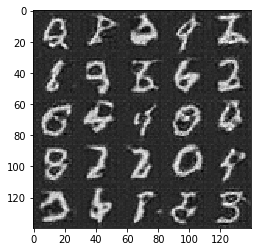

Epoch 1/2... Discriminator Loss: 1.6618... Generator Loss: 0.4251
Epoch 1/2... Discriminator Loss: 0.7444... Generator Loss: 1.2353
Epoch 2/2... Discriminator Loss: 0.3994... Generator Loss: 3.0308
Epoch 2/2... Discriminator Loss: 0.7844... Generator Loss: 1.2375
Epoch 2/2... Discriminator Loss: 0.6637... Generator Loss: 1.3587


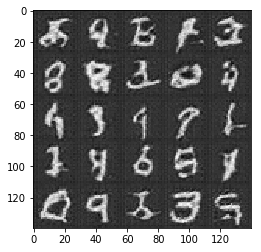

Epoch 2/2... Discriminator Loss: 0.6887... Generator Loss: 1.6465
Epoch 2/2... Discriminator Loss: 0.3718... Generator Loss: 3.5095
Epoch 2/2... Discriminator Loss: 0.7987... Generator Loss: 2.3773
Epoch 2/2... Discriminator Loss: 0.6838... Generator Loss: 1.4408
Epoch 2/2... Discriminator Loss: 0.8148... Generator Loss: 1.3546


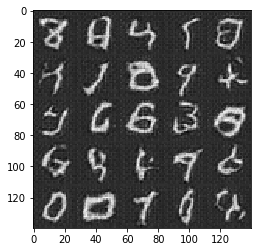

Epoch 2/2... Discriminator Loss: 0.3627... Generator Loss: 4.9277
Epoch 2/2... Discriminator Loss: 0.9738... Generator Loss: 0.8766
Epoch 2/2... Discriminator Loss: 0.3522... Generator Loss: 4.1535
Epoch 2/2... Discriminator Loss: 1.0560... Generator Loss: 0.7113
Epoch 2/2... Discriminator Loss: 0.9954... Generator Loss: 0.8869


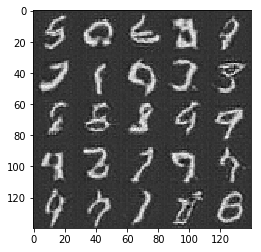

Epoch 2/2... Discriminator Loss: 0.3442... Generator Loss: 5.6413
Epoch 2/2... Discriminator Loss: 0.8372... Generator Loss: 1.1668
Epoch 2/2... Discriminator Loss: 2.4051... Generator Loss: 0.1826
Epoch 2/2... Discriminator Loss: 0.6192... Generator Loss: 1.6121
Epoch 2/2... Discriminator Loss: 1.0044... Generator Loss: 0.9597


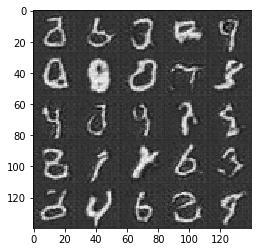

Epoch 2/2... Discriminator Loss: 1.3577... Generator Loss: 0.5158
Epoch 2/2... Discriminator Loss: 0.5196... Generator Loss: 2.1641
Epoch 2/2... Discriminator Loss: 0.4740... Generator Loss: 2.7568
Epoch 2/2... Discriminator Loss: 1.4290... Generator Loss: 0.4737
Epoch 2/2... Discriminator Loss: 0.8225... Generator Loss: 4.4888


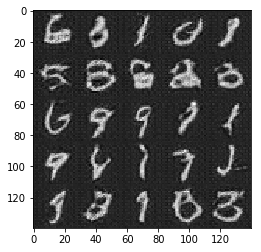

Epoch 2/2... Discriminator Loss: 0.3755... Generator Loss: 6.9035
Epoch 2/2... Discriminator Loss: 0.3458... Generator Loss: 4.2548
Epoch 2/2... Discriminator Loss: 0.6128... Generator Loss: 2.0459
Epoch 2/2... Discriminator Loss: 0.9734... Generator Loss: 0.8336
Epoch 2/2... Discriminator Loss: 0.7282... Generator Loss: 1.2725


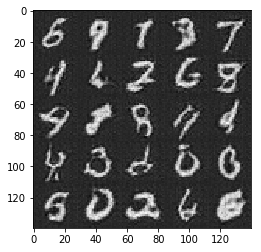

Epoch 2/2... Discriminator Loss: 0.7609... Generator Loss: 1.2540
Epoch 2/2... Discriminator Loss: 0.5400... Generator Loss: 1.9786
Epoch 2/2... Discriminator Loss: 0.9847... Generator Loss: 0.8877
Epoch 2/2... Discriminator Loss: 0.4166... Generator Loss: 3.2916
Epoch 2/2... Discriminator Loss: 0.3620... Generator Loss: 4.7244


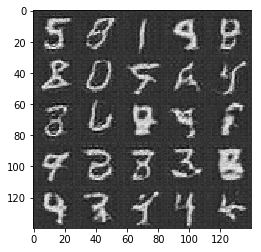

Epoch 2/2... Discriminator Loss: 1.2823... Generator Loss: 0.6169
Epoch 2/2... Discriminator Loss: 1.0147... Generator Loss: 0.9475
Epoch 2/2... Discriminator Loss: 0.7335... Generator Loss: 1.4740
Epoch 2/2... Discriminator Loss: 0.4522... Generator Loss: 2.8178
Epoch 2/2... Discriminator Loss: 0.4545... Generator Loss: 3.7740


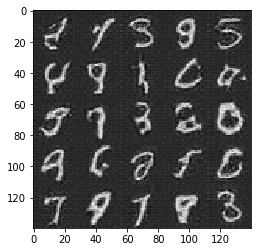

Epoch 2/2... Discriminator Loss: 0.7410... Generator Loss: 1.2645
Epoch 2/2... Discriminator Loss: 0.3422... Generator Loss: 5.2534


In [ ]:
batch_size = 16
z_dim = 256
learning_rate = 0.0002
beta1 = 0.1
print_every = 20
show_every = 100
n_images = 25


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.8057... Generator Loss: 0.0230
Epoch 1/1... Discriminator Loss: 2.3832... Generator Loss: 0.2146
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.5345
Epoch 1/1... Discriminator Loss: 0.5171... Generator Loss: 2.2218
Epoch 1/1... Discriminator Loss: 0.5097... Generator Loss: 2.0437
Epoch 1/1... Discriminator Loss: 0.4110... Generator Loss: 2.7521


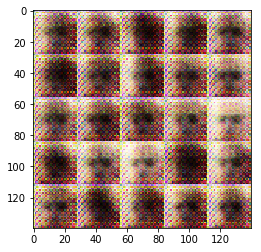

Epoch 1/1... Discriminator Loss: 0.3615... Generator Loss: 4.0302
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.5707
Epoch 1/1... Discriminator Loss: 0.4609... Generator Loss: 2.3957
Epoch 1/1... Discriminator Loss: 0.5478... Generator Loss: 2.1423
Epoch 1/1... Discriminator Loss: 2.5481... Generator Loss: 0.1320
Epoch 1/1... Discriminator Loss: 1.5931... Generator Loss: 0.4036
Epoch 1/1... Discriminator Loss: 0.3823... Generator Loss: 3.2470


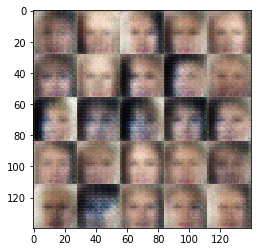

Epoch 1/1... Discriminator Loss: 0.3548... Generator Loss: 4.3962
Epoch 1/1... Discriminator Loss: 0.7954... Generator Loss: 1.8213
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 0.3461... Generator Loss: 5.7624
Epoch 1/1... Discriminator Loss: 0.5651... Generator Loss: 1.6954
Epoch 1/1... Discriminator Loss: 0.8506... Generator Loss: 5.9623
Epoch 1/1... Discriminator Loss: 0.5062... Generator Loss: 1.9816


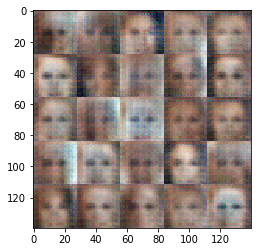

Epoch 1/1... Discriminator Loss: 0.3686... Generator Loss: 7.2400
Epoch 1/1... Discriminator Loss: 0.3613... Generator Loss: 4.7476
Epoch 1/1... Discriminator Loss: 0.3546... Generator Loss: 5.4926
Epoch 1/1... Discriminator Loss: 0.3302... Generator Loss: 8.1977
Epoch 1/1... Discriminator Loss: 0.3873... Generator Loss: 3.8363
Epoch 1/1... Discriminator Loss: 0.4419... Generator Loss: 2.6152


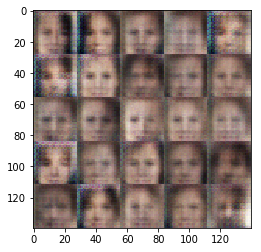

Epoch 1/1... Discriminator Loss: 0.3906... Generator Loss: 3.0019
Epoch 1/1... Discriminator Loss: 1.6482... Generator Loss: 0.3315
Epoch 1/1... Discriminator Loss: 0.3628... Generator Loss: 6.1289
Epoch 1/1... Discriminator Loss: 0.8930... Generator Loss: 3.1571
Epoch 1/1... Discriminator Loss: 0.3454... Generator Loss: 4.7419
Epoch 1/1... Discriminator Loss: 0.3816... Generator Loss: 4.3025
Epoch 1/1... Discriminator Loss: 0.4335... Generator Loss: 5.2008


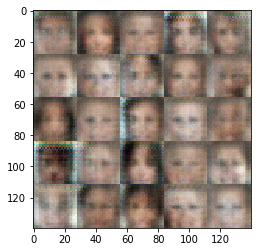

Epoch 1/1... Discriminator Loss: 0.3610... Generator Loss: 6.0508
Epoch 1/1... Discriminator Loss: 0.3473... Generator Loss: 5.1395
Epoch 1/1... Discriminator Loss: 0.3353... Generator Loss: 6.8634
Epoch 1/1... Discriminator Loss: 0.5880... Generator Loss: 4.3520
Epoch 1/1... Discriminator Loss: 0.7457... Generator Loss: 3.0743
Epoch 1/1... Discriminator Loss: 0.4922... Generator Loss: 2.2744
Epoch 1/1... Discriminator Loss: 0.5049... Generator Loss: 3.0283


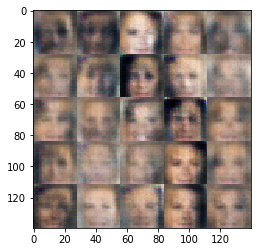

Epoch 1/1... Discriminator Loss: 1.6810... Generator Loss: 0.4052
Epoch 1/1... Discriminator Loss: 1.8243... Generator Loss: 2.2110
Epoch 1/1... Discriminator Loss: 0.5070... Generator Loss: 7.1857
Epoch 1/1... Discriminator Loss: 0.3895... Generator Loss: 3.1313
Epoch 1/1... Discriminator Loss: 0.5204... Generator Loss: 4.0163
Epoch 1/1... Discriminator Loss: 2.6764... Generator Loss: 6.1150


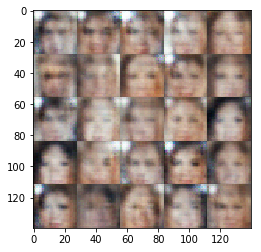

Epoch 1/1... Discriminator Loss: 0.4184... Generator Loss: 3.7313
Epoch 1/1... Discriminator Loss: 0.4711... Generator Loss: 2.4591
Epoch 1/1... Discriminator Loss: 0.3362... Generator Loss: 9.2068
Epoch 1/1... Discriminator Loss: 0.4805... Generator Loss: 2.2894
Epoch 1/1... Discriminator Loss: 0.4083... Generator Loss: 4.4728
Epoch 1/1... Discriminator Loss: 0.4131... Generator Loss: 3.4223
Epoch 1/1... Discriminator Loss: 0.5536... Generator Loss: 2.2809


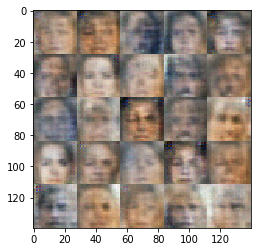

Epoch 1/1... Discriminator Loss: 0.8778... Generator Loss: 1.0193
Epoch 1/1... Discriminator Loss: 1.7337... Generator Loss: 3.6809
Epoch 1/1... Discriminator Loss: 0.4465... Generator Loss: 2.6334
Epoch 1/1... Discriminator Loss: 0.3431... Generator Loss: 6.3178
Epoch 1/1... Discriminator Loss: 0.3571... Generator Loss: 4.3312
Epoch 1/1... Discriminator Loss: 0.6770... Generator Loss: 1.4215
Epoch 1/1... Discriminator Loss: 0.4267... Generator Loss: 2.8070


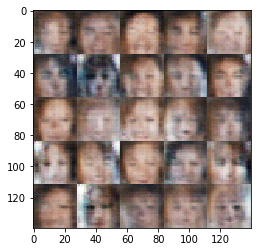

Epoch 1/1... Discriminator Loss: 0.4854... Generator Loss: 2.7264
Epoch 1/1... Discriminator Loss: 0.4702... Generator Loss: 2.2986
Epoch 1/1... Discriminator Loss: 0.4323... Generator Loss: 3.8946
Epoch 1/1... Discriminator Loss: 0.3863... Generator Loss: 3.6766
Epoch 1/1... Discriminator Loss: 0.6514... Generator Loss: 1.5676
Epoch 1/1... Discriminator Loss: 0.7148... Generator Loss: 1.8607


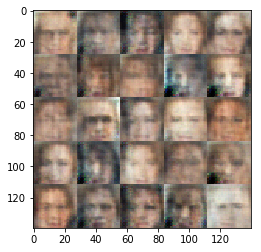

Epoch 1/1... Discriminator Loss: 0.3324... Generator Loss: 6.7485
Epoch 1/1... Discriminator Loss: 0.3382... Generator Loss: 6.0186
Epoch 1/1... Discriminator Loss: 0.4993... Generator Loss: 3.9179
Epoch 1/1... Discriminator Loss: 1.7367... Generator Loss: 3.2891
Epoch 1/1... Discriminator Loss: 0.3556... Generator Loss: 4.6496
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 0.9840
Epoch 1/1... Discriminator Loss: 0.3649... Generator Loss: 3.8934


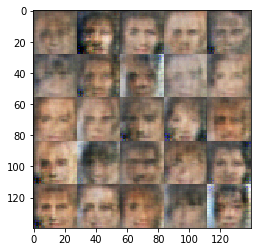

Epoch 1/1... Discriminator Loss: 0.7911... Generator Loss: 1.1480
Epoch 1/1... Discriminator Loss: 0.8533... Generator Loss: 1.0553
Epoch 1/1... Discriminator Loss: 0.3547... Generator Loss: 4.6950
Epoch 1/1... Discriminator Loss: 0.3517... Generator Loss: 4.5997
Epoch 1/1... Discriminator Loss: 0.7242... Generator Loss: 10.7808
Epoch 1/1... Discriminator Loss: 0.4971... Generator Loss: 2.1204
Epoch 1/1... Discriminator Loss: 0.3327... Generator Loss: 7.4277


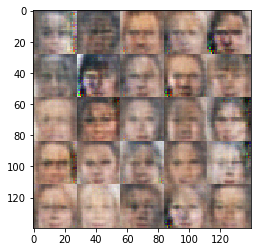

Epoch 1/1... Discriminator Loss: 0.5503... Generator Loss: 1.8719
Epoch 1/1... Discriminator Loss: 0.9156... Generator Loss: 3.2126
Epoch 1/1... Discriminator Loss: 0.7294... Generator Loss: 1.1639
Epoch 1/1... Discriminator Loss: 0.3367... Generator Loss: 5.6996
Epoch 1/1... Discriminator Loss: 0.9277... Generator Loss: 0.8920
Epoch 1/1... Discriminator Loss: 0.3638... Generator Loss: 4.5971


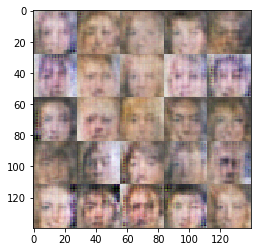

Epoch 1/1... Discriminator Loss: 0.3909... Generator Loss: 3.9545
Epoch 1/1... Discriminator Loss: 0.3648... Generator Loss: 3.6266
Epoch 1/1... Discriminator Loss: 0.4026... Generator Loss: 3.0482
Epoch 1/1... Discriminator Loss: 1.0173... Generator Loss: 1.3487
Epoch 1/1... Discriminator Loss: 0.3379... Generator Loss: 5.4512
Epoch 1/1... Discriminator Loss: 0.3559... Generator Loss: 6.5811
Epoch 1/1... Discriminator Loss: 0.3590... Generator Loss: 4.1243


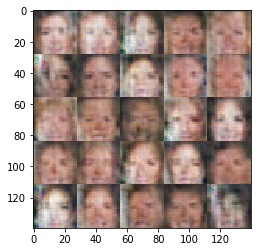

Epoch 1/1... Discriminator Loss: 0.3415... Generator Loss: 5.4021
Epoch 1/1... Discriminator Loss: 0.3477... Generator Loss: 4.4256
Epoch 1/1... Discriminator Loss: 0.3494... Generator Loss: 4.2108
Epoch 1/1... Discriminator Loss: 0.6130... Generator Loss: 5.4317
Epoch 1/1... Discriminator Loss: 0.3403... Generator Loss: 7.4904
Epoch 1/1... Discriminator Loss: 0.3957... Generator Loss: 3.9435
Epoch 1/1... Discriminator Loss: 0.3935... Generator Loss: 2.8833


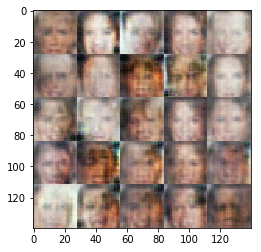

Epoch 1/1... Discriminator Loss: 0.5977... Generator Loss: 1.9717
Epoch 1/1... Discriminator Loss: 0.4169... Generator Loss: 2.8034
Epoch 1/1... Discriminator Loss: 0.3411... Generator Loss: 5.3203
Epoch 1/1... Discriminator Loss: 0.3560... Generator Loss: 3.8882
Epoch 1/1... Discriminator Loss: 0.4201... Generator Loss: 4.0832
Epoch 1/1... Discriminator Loss: 0.6520... Generator Loss: 1.5467


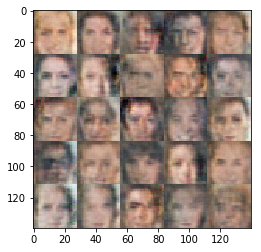

Epoch 1/1... Discriminator Loss: 0.3820... Generator Loss: 5.9359
Epoch 1/1... Discriminator Loss: 0.4655... Generator Loss: 7.8851
Epoch 1/1... Discriminator Loss: 0.3602... Generator Loss: 3.7463
Epoch 1/1... Discriminator Loss: 0.3441... Generator Loss: 5.7548
Epoch 1/1... Discriminator Loss: 0.3294... Generator Loss: 9.3371
Epoch 1/1... Discriminator Loss: 0.6069... Generator Loss: 8.5923
Epoch 1/1... Discriminator Loss: 0.3612... Generator Loss: 3.6473


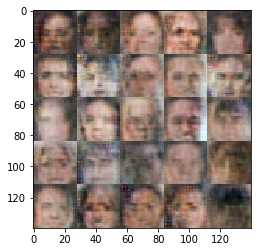

Epoch 1/1... Discriminator Loss: 0.3469... Generator Loss: 4.3718
Epoch 1/1... Discriminator Loss: 0.4073... Generator Loss: 2.6892
Epoch 1/1... Discriminator Loss: 0.3997... Generator Loss: 2.7817
Epoch 1/1... Discriminator Loss: 0.3439... Generator Loss: 6.1119
Epoch 1/1... Discriminator Loss: 1.7677... Generator Loss: 0.3263
Epoch 1/1... Discriminator Loss: 0.6140... Generator Loss: 1.5215
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.5182


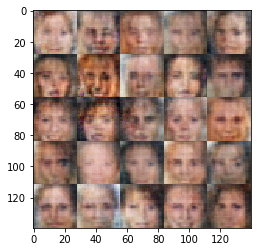

Epoch 1/1... Discriminator Loss: 0.4030... Generator Loss: 7.2826
Epoch 1/1... Discriminator Loss: 0.3363... Generator Loss: 6.3293
Epoch 1/1... Discriminator Loss: 0.4490... Generator Loss: 2.5983
Epoch 1/1... Discriminator Loss: 0.3352... Generator Loss: 5.2339
Epoch 1/1... Discriminator Loss: 0.3305... Generator Loss: 6.5773
Epoch 1/1... Discriminator Loss: 0.9725... Generator Loss: 7.6906


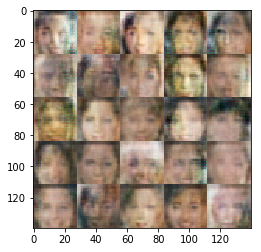

Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 6.3953
Epoch 1/1... Discriminator Loss: 0.4948... Generator Loss: 2.0851
Epoch 1/1... Discriminator Loss: 0.4258... Generator Loss: 2.5323
Epoch 1/1... Discriminator Loss: 0.3324... Generator Loss: 8.8542
Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 0.3978... Generator Loss: 3.1195
Epoch 1/1... Discriminator Loss: 0.4703... Generator Loss: 3.5024


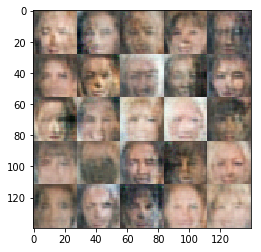

Epoch 1/1... Discriminator Loss: 0.4725... Generator Loss: 3.6558
Epoch 1/1... Discriminator Loss: 0.3748... Generator Loss: 8.3328
Epoch 1/1... Discriminator Loss: 0.8107... Generator Loss: 1.0752
Epoch 1/1... Discriminator Loss: 0.3436... Generator Loss: 5.2041
Epoch 1/1... Discriminator Loss: 0.3480... Generator Loss: 4.3123
Epoch 1/1... Discriminator Loss: 0.3602... Generator Loss: 6.3881
Epoch 1/1... Discriminator Loss: 0.3376... Generator Loss: 7.7312


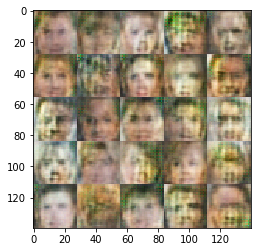

Epoch 1/1... Discriminator Loss: 0.3337... Generator Loss: 7.5086
Epoch 1/1... Discriminator Loss: 0.7362... Generator Loss: 7.7009
Epoch 1/1... Discriminator Loss: 0.3323... Generator Loss: 6.4599
Epoch 1/1... Discriminator Loss: 0.5487... Generator Loss: 1.8320
Epoch 1/1... Discriminator Loss: 0.6889... Generator Loss: 6.2609
Epoch 1/1... Discriminator Loss: 0.5325... Generator Loss: 1.9304


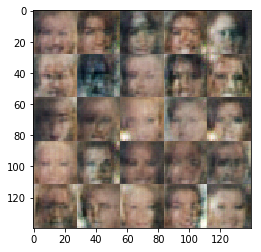

Epoch 1/1... Discriminator Loss: 0.3758... Generator Loss: 3.6707
Epoch 1/1... Discriminator Loss: 0.3532... Generator Loss: 4.0208
Epoch 1/1... Discriminator Loss: 1.8902... Generator Loss: 5.5085
Epoch 1/1... Discriminator Loss: 0.8841... Generator Loss: 6.3118
Epoch 1/1... Discriminator Loss: 0.3797... Generator Loss: 3.0972
Epoch 1/1... Discriminator Loss: 0.6828... Generator Loss: 1.3328
Epoch 1/1... Discriminator Loss: 0.8061... Generator Loss: 1.1302


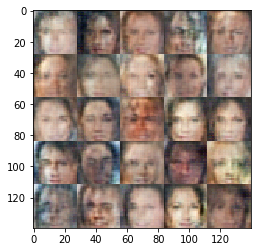

Epoch 1/1... Discriminator Loss: 0.5226... Generator Loss: 2.0844
Epoch 1/1... Discriminator Loss: 0.9298... Generator Loss: 0.8855
Epoch 1/1... Discriminator Loss: 0.4400... Generator Loss: 2.7173
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.4675
Epoch 1/1... Discriminator Loss: 0.3306... Generator Loss: 7.3937
Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 0.6546... Generator Loss: 1.4440


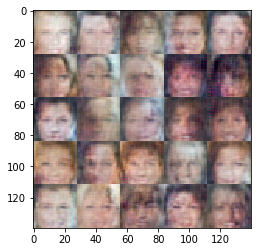

Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.5985
Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 0.6191
Epoch 1/1... Discriminator Loss: 0.3425... Generator Loss: 5.0802
Epoch 1/1... Discriminator Loss: 0.4936... Generator Loss: 1.9556
Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 0.5792
Epoch 1/1... Discriminator Loss: 2.4898... Generator Loss: 6.1082


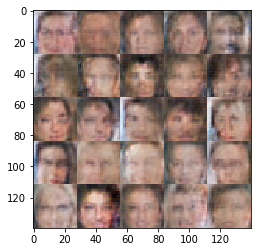

Epoch 1/1... Discriminator Loss: 0.3434... Generator Loss: 4.8186
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.4982
Epoch 1/1... Discriminator Loss: 0.4490... Generator Loss: 3.5944
Epoch 1/1... Discriminator Loss: 0.4866... Generator Loss: 2.4465
Epoch 1/1... Discriminator Loss: 2.6005... Generator Loss: 3.9894
Epoch 1/1... Discriminator Loss: 0.7513... Generator Loss: 1.2473
Epoch 1/1... Discriminator Loss: 0.5285... Generator Loss: 1.9974


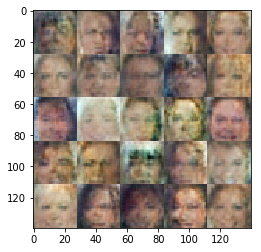

Epoch 1/1... Discriminator Loss: 0.3342... Generator Loss: 6.9654
Epoch 1/1... Discriminator Loss: 0.3363... Generator Loss: 5.7416
Epoch 1/1... Discriminator Loss: 0.4588... Generator Loss: 8.3514
Epoch 1/1... Discriminator Loss: 0.4034... Generator Loss: 7.8496
Epoch 1/1... Discriminator Loss: 0.3580... Generator Loss: 4.3565
Epoch 1/1... Discriminator Loss: 0.3514... Generator Loss: 6.2551
Epoch 1/1... Discriminator Loss: 0.3614... Generator Loss: 3.6276


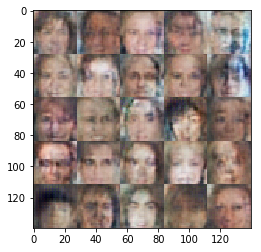

Epoch 1/1... Discriminator Loss: 0.6555... Generator Loss: 1.3865
Epoch 1/1... Discriminator Loss: 0.8350... Generator Loss: 1.0406
Epoch 1/1... Discriminator Loss: 0.3456... Generator Loss: 6.3771
Epoch 1/1... Discriminator Loss: 0.3469... Generator Loss: 4.4906
Epoch 1/1... Discriminator Loss: 0.5001... Generator Loss: 2.0091
Epoch 1/1... Discriminator Loss: 0.5145... Generator Loss: 1.9244


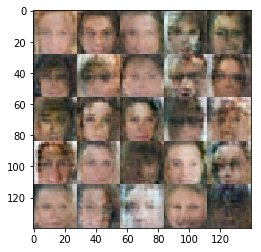

Epoch 1/1... Discriminator Loss: 0.6819... Generator Loss: 4.1000
Epoch 1/1... Discriminator Loss: 0.3576... Generator Loss: 4.3175
Epoch 1/1... Discriminator Loss: 1.5937... Generator Loss: 0.3502
Epoch 1/1... Discriminator Loss: 0.5145... Generator Loss: 2.1967
Epoch 1/1... Discriminator Loss: 0.3344... Generator Loss: 6.5202
Epoch 1/1... Discriminator Loss: 0.6115... Generator Loss: 1.4365
Epoch 1/1... Discriminator Loss: 0.6191... Generator Loss: 1.8916


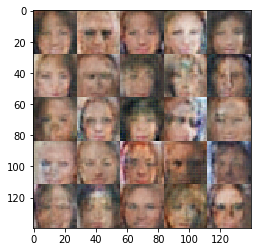

Epoch 1/1... Discriminator Loss: 0.8759... Generator Loss: 0.9113
Epoch 1/1... Discriminator Loss: 0.4188... Generator Loss: 2.8272
Epoch 1/1... Discriminator Loss: 0.3663... Generator Loss: 6.4399
Epoch 1/1... Discriminator Loss: 0.5617... Generator Loss: 1.6949
Epoch 1/1... Discriminator Loss: 0.3351... Generator Loss: 8.0068
Epoch 1/1... Discriminator Loss: 0.3986... Generator Loss: 2.9936
Epoch 1/1... Discriminator Loss: 0.3329... Generator Loss: 6.8667


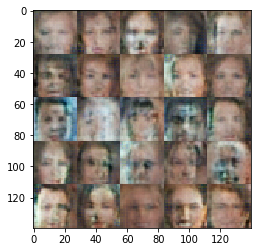

Epoch 1/1... Discriminator Loss: 0.3545... Generator Loss: 4.1059
Epoch 1/1... Discriminator Loss: 0.3943... Generator Loss: 3.1925
Epoch 1/1... Discriminator Loss: 1.5395... Generator Loss: 2.7890
Epoch 1/1... Discriminator Loss: 0.9823... Generator Loss: 1.2679
Epoch 1/1... Discriminator Loss: 0.4770... Generator Loss: 2.2044
Epoch 1/1... Discriminator Loss: 0.7744... Generator Loss: 1.0792


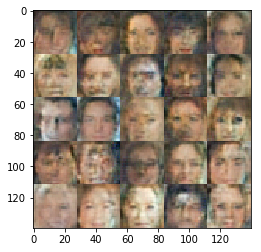

Epoch 1/1... Discriminator Loss: 0.5234... Generator Loss: 1.8536
Epoch 1/1... Discriminator Loss: 0.4719... Generator Loss: 2.0616
Epoch 1/1... Discriminator Loss: 0.5675... Generator Loss: 1.6053
Epoch 1/1... Discriminator Loss: 1.4889... Generator Loss: 0.4274
Epoch 1/1... Discriminator Loss: 0.8564... Generator Loss: 0.9283
Epoch 1/1... Discriminator Loss: 0.5788... Generator Loss: 1.6266
Epoch 1/1... Discriminator Loss: 0.3848... Generator Loss: 4.4514


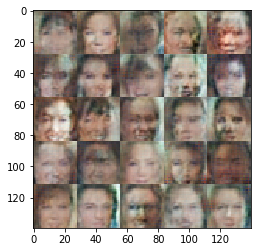

Epoch 1/1... Discriminator Loss: 0.9499... Generator Loss: 4.3824
Epoch 1/1... Discriminator Loss: 1.6510... Generator Loss: 3.9681
Epoch 1/1... Discriminator Loss: 0.4568... Generator Loss: 2.3377
Epoch 1/1... Discriminator Loss: 0.3388... Generator Loss: 7.0657
Epoch 1/1... Discriminator Loss: 0.3320... Generator Loss: 7.8967
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.4951
Epoch 1/1... Discriminator Loss: 0.8858... Generator Loss: 1.0050


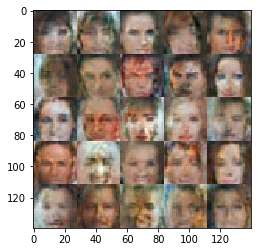

Epoch 1/1... Discriminator Loss: 0.5028... Generator Loss: 1.9815
Epoch 1/1... Discriminator Loss: 0.6181... Generator Loss: 1.4408
Epoch 1/1... Discriminator Loss: 0.3596... Generator Loss: 5.9266
Epoch 1/1... Discriminator Loss: 1.7889... Generator Loss: 3.1818
Epoch 1/1... Discriminator Loss: 0.3644... Generator Loss: 3.5016
Epoch 1/1... Discriminator Loss: 0.3343... Generator Loss: 5.8902


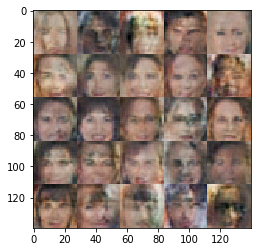

Epoch 1/1... Discriminator Loss: 0.3438... Generator Loss: 5.0895
Epoch 1/1... Discriminator Loss: 0.7154... Generator Loss: 1.2499
Epoch 1/1... Discriminator Loss: 0.5599... Generator Loss: 7.0443
Epoch 1/1... Discriminator Loss: 0.6085... Generator Loss: 5.6384
Epoch 1/1... Discriminator Loss: 0.7779... Generator Loss: 1.0798
Epoch 1/1... Discriminator Loss: 0.5205... Generator Loss: 2.0096
Epoch 1/1... Discriminator Loss: 0.4223... Generator Loss: 2.5520


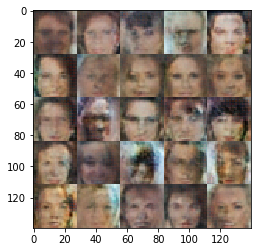

Epoch 1/1... Discriminator Loss: 1.0170... Generator Loss: 4.4320
Epoch 1/1... Discriminator Loss: 0.3557... Generator Loss: 4.1485
Epoch 1/1... Discriminator Loss: 0.4972... Generator Loss: 2.1987
Epoch 1/1... Discriminator Loss: 0.4965... Generator Loss: 2.1779
Epoch 1/1... Discriminator Loss: 0.8372... Generator Loss: 0.9671
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 6.0234
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.5008


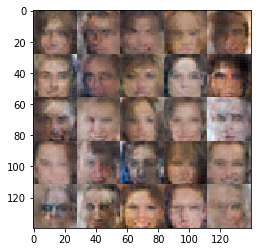

Epoch 1/1... Discriminator Loss: 0.4387... Generator Loss: 2.4823
Epoch 1/1... Discriminator Loss: 0.3384... Generator Loss: 5.7779
Epoch 1/1... Discriminator Loss: 0.5058... Generator Loss: 5.9515
Epoch 1/1... Discriminator Loss: 0.3652... Generator Loss: 3.4907
Epoch 1/1... Discriminator Loss: 1.5047... Generator Loss: 0.4566
Epoch 1/1... Discriminator Loss: 0.8032... Generator Loss: 1.1059


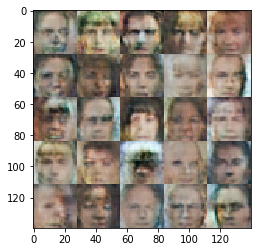

Epoch 1/1... Discriminator Loss: 0.4165... Generator Loss: 5.0142
Epoch 1/1... Discriminator Loss: 0.4455... Generator Loss: 3.0482
Epoch 1/1... Discriminator Loss: 1.0094... Generator Loss: 1.9243
Epoch 1/1... Discriminator Loss: 0.3742... Generator Loss: 5.9948
Epoch 1/1... Discriminator Loss: 1.6952... Generator Loss: 0.3407
Epoch 1/1... Discriminator Loss: 0.8938... Generator Loss: 0.9888
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 1.1293


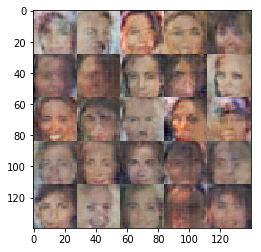

Epoch 1/1... Discriminator Loss: 0.5582... Generator Loss: 2.5213
Epoch 1/1... Discriminator Loss: 0.7373... Generator Loss: 3.3754
Epoch 1/1... Discriminator Loss: 0.5302... Generator Loss: 2.0970
Epoch 1/1... Discriminator Loss: 0.5366... Generator Loss: 2.1436
Epoch 1/1... Discriminator Loss: 0.3728... Generator Loss: 3.9540
Epoch 1/1... Discriminator Loss: 0.9243... Generator Loss: 0.9401
Epoch 1/1... Discriminator Loss: 1.2269... Generator Loss: 0.5946


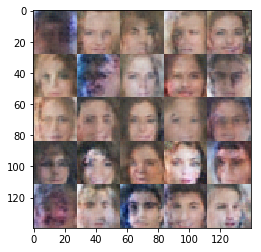

Epoch 1/1... Discriminator Loss: 0.4420... Generator Loss: 2.6688
Epoch 1/1... Discriminator Loss: 0.5244... Generator Loss: 1.9802
Epoch 1/1... Discriminator Loss: 1.6516... Generator Loss: 0.4186
Epoch 1/1... Discriminator Loss: 0.3577... Generator Loss: 5.4045
Epoch 1/1... Discriminator Loss: 0.4761... Generator Loss: 2.1965
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.5653


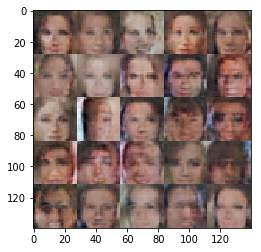

Epoch 1/1... Discriminator Loss: 0.3329... Generator Loss: 6.5215
Epoch 1/1... Discriminator Loss: 2.2013... Generator Loss: 0.2385
Epoch 1/1... Discriminator Loss: 0.4859... Generator Loss: 2.0774
Epoch 1/1... Discriminator Loss: 0.5929... Generator Loss: 3.0073
Epoch 1/1... Discriminator Loss: 0.6482... Generator Loss: 1.4506
Epoch 1/1... Discriminator Loss: 0.3690... Generator Loss: 3.7064
Epoch 1/1... Discriminator Loss: 0.3811... Generator Loss: 3.4541


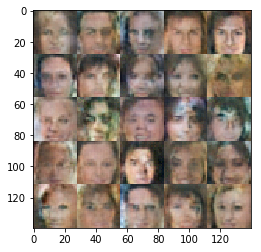

Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 0.9896
Epoch 1/1... Discriminator Loss: 0.3795... Generator Loss: 3.2860
Epoch 1/1... Discriminator Loss: 0.4968... Generator Loss: 2.5569
Epoch 1/1... Discriminator Loss: 0.3342... Generator Loss: 6.2701
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.7973... Generator Loss: 2.9282
Epoch 1/1... Discriminator Loss: 0.3992... Generator Loss: 3.2257


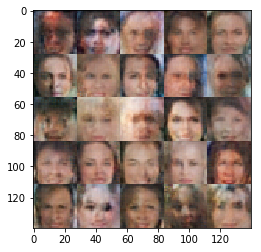

Epoch 1/1... Discriminator Loss: 0.8244... Generator Loss: 4.8946
Epoch 1/1... Discriminator Loss: 0.8024... Generator Loss: 2.9051
Epoch 1/1... Discriminator Loss: 0.9996... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 0.3539... Generator Loss: 4.6150
Epoch 1/1... Discriminator Loss: 0.3957... Generator Loss: 2.9694
Epoch 1/1... Discriminator Loss: 0.4354... Generator Loss: 2.9571


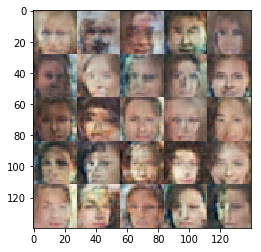

Epoch 1/1... Discriminator Loss: 0.5080... Generator Loss: 6.4449
Epoch 1/1... Discriminator Loss: 1.0148... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 2.0343... Generator Loss: 0.2482
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.5449
Epoch 1/1... Discriminator Loss: 0.3812... Generator Loss: 3.3891
Epoch 1/1... Discriminator Loss: 1.2577... Generator Loss: 0.5971
Epoch 1/1... Discriminator Loss: 0.4511... Generator Loss: 2.4186


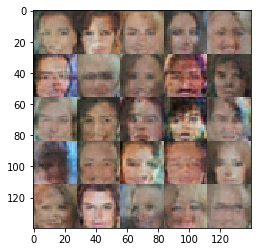

Epoch 1/1... Discriminator Loss: 0.7072... Generator Loss: 2.2429
Epoch 1/1... Discriminator Loss: 0.7540... Generator Loss: 1.4303
Epoch 1/1... Discriminator Loss: 0.4867... Generator Loss: 2.2077
Epoch 1/1... Discriminator Loss: 1.0467... Generator Loss: 1.6438
Epoch 1/1... Discriminator Loss: 3.2064... Generator Loss: 0.0781
Epoch 1/1... Discriminator Loss: 0.5217... Generator Loss: 3.8447
Epoch 1/1... Discriminator Loss: 2.8498... Generator Loss: 0.1073


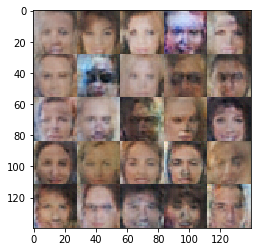

Epoch 1/1... Discriminator Loss: 0.4793... Generator Loss: 2.8933
Epoch 1/1... Discriminator Loss: 0.6927... Generator Loss: 1.2671
Epoch 1/1... Discriminator Loss: 0.8719... Generator Loss: 1.0288
Epoch 1/1... Discriminator Loss: 1.5157... Generator Loss: 0.4391
Epoch 1/1... Discriminator Loss: 1.0290... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 0.3766... Generator Loss: 4.6755


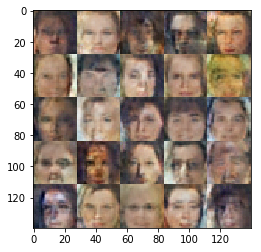

Epoch 1/1... Discriminator Loss: 0.9107... Generator Loss: 0.9687
Epoch 1/1... Discriminator Loss: 0.5568... Generator Loss: 1.7626
Epoch 1/1... Discriminator Loss: 0.3431... Generator Loss: 5.6705
Epoch 1/1... Discriminator Loss: 0.3818... Generator Loss: 5.3485
Epoch 1/1... Discriminator Loss: 0.4506... Generator Loss: 4.5643
Epoch 1/1... Discriminator Loss: 0.3478... Generator Loss: 5.0724
Epoch 1/1... Discriminator Loss: 1.7113... Generator Loss: 0.3177


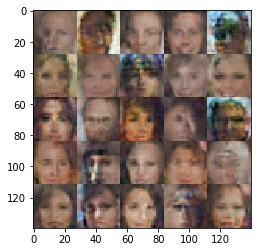

Epoch 1/1... Discriminator Loss: 0.4123... Generator Loss: 4.0310
Epoch 1/1... Discriminator Loss: 0.3465... Generator Loss: 4.4503
Epoch 1/1... Discriminator Loss: 0.6905... Generator Loss: 1.4206
Epoch 1/1... Discriminator Loss: 0.3674... Generator Loss: 3.6635
Epoch 1/1... Discriminator Loss: 0.3745... Generator Loss: 3.9581
Epoch 1/1... Discriminator Loss: 2.1563... Generator Loss: 0.2014
Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 0.6117


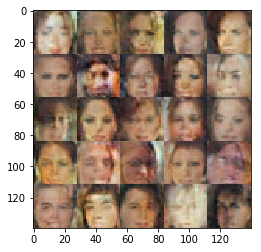

Epoch 1/1... Discriminator Loss: 0.5102... Generator Loss: 1.9511
Epoch 1/1... Discriminator Loss: 0.8037... Generator Loss: 2.6220
Epoch 1/1... Discriminator Loss: 0.9524... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 0.5551... Generator Loss: 1.7007
Epoch 1/1... Discriminator Loss: 0.3497... Generator Loss: 4.5565
Epoch 1/1... Discriminator Loss: 0.8654... Generator Loss: 0.9785


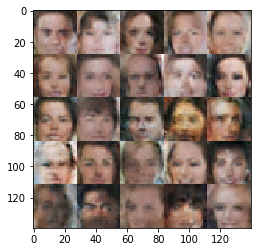

Epoch 1/1... Discriminator Loss: 0.7527... Generator Loss: 2.8223
Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 0.3936... Generator Loss: 3.0905
Epoch 1/1... Discriminator Loss: 0.4933... Generator Loss: 4.9821
Epoch 1/1... Discriminator Loss: 0.4387... Generator Loss: 4.7294
Epoch 1/1... Discriminator Loss: 0.4143... Generator Loss: 3.8605
Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 0.6421


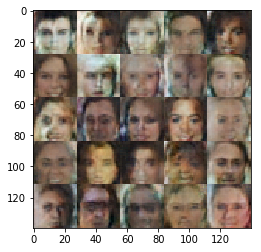

Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 0.5413
Epoch 1/1... Discriminator Loss: 0.4161... Generator Loss: 3.7202
Epoch 1/1... Discriminator Loss: 0.3516... Generator Loss: 4.5929
Epoch 1/1... Discriminator Loss: 0.7545... Generator Loss: 1.2686
Epoch 1/1... Discriminator Loss: 0.3439... Generator Loss: 4.4944
Epoch 1/1... Discriminator Loss: 0.3960... Generator Loss: 3.5323
Epoch 1/1... Discriminator Loss: 0.6220... Generator Loss: 4.0415


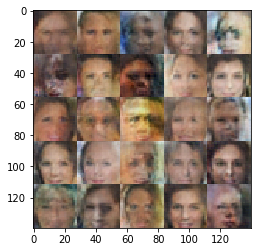

Epoch 1/1... Discriminator Loss: 0.5070... Generator Loss: 2.0819
Epoch 1/1... Discriminator Loss: 2.0205... Generator Loss: 3.1891
Epoch 1/1... Discriminator Loss: 0.6098... Generator Loss: 1.5744
Epoch 1/1... Discriminator Loss: 0.6455... Generator Loss: 2.0955
Epoch 1/1... Discriminator Loss: 0.5146... Generator Loss: 1.9554
Epoch 1/1... Discriminator Loss: 0.3520... Generator Loss: 4.2201


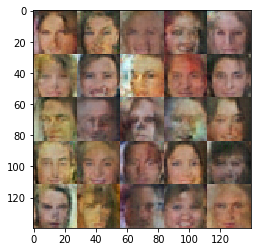

Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 0.4093... Generator Loss: 2.9813
Epoch 1/1... Discriminator Loss: 1.6064... Generator Loss: 0.3572
Epoch 1/1... Discriminator Loss: 0.8641... Generator Loss: 1.3657
Epoch 1/1... Discriminator Loss: 0.4319... Generator Loss: 3.9946
Epoch 1/1... Discriminator Loss: 1.0600... Generator Loss: 0.8389
Epoch 1/1... Discriminator Loss: 0.3471... Generator Loss: 5.4567


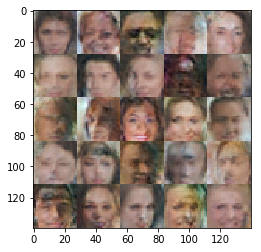

Epoch 1/1... Discriminator Loss: 1.5250... Generator Loss: 0.4282
Epoch 1/1... Discriminator Loss: 1.0365... Generator Loss: 1.0627
Epoch 1/1... Discriminator Loss: 0.9396... Generator Loss: 1.4849
Epoch 1/1... Discriminator Loss: 0.6283... Generator Loss: 1.4668
Epoch 1/1... Discriminator Loss: 0.4384... Generator Loss: 2.7015
Epoch 1/1... Discriminator Loss: 0.5035... Generator Loss: 2.1667
Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 1.6899


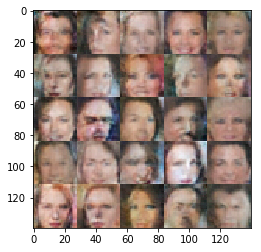

Epoch 1/1... Discriminator Loss: 0.7619... Generator Loss: 1.1092
Epoch 1/1... Discriminator Loss: 0.5669... Generator Loss: 5.8228
Epoch 1/1... Discriminator Loss: 1.1744... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 0.5483... Generator Loss: 4.3191
Epoch 1/1... Discriminator Loss: 0.6589... Generator Loss: 3.2797
Epoch 1/1... Discriminator Loss: 0.4738... Generator Loss: 2.3407


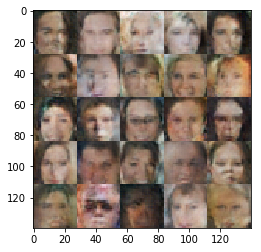

Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 0.4049... Generator Loss: 2.8752
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 2.1081
Epoch 1/1... Discriminator Loss: 0.4823... Generator Loss: 2.4362
Epoch 1/1... Discriminator Loss: 0.6021... Generator Loss: 1.6295
Epoch 1/1... Discriminator Loss: 0.6186... Generator Loss: 2.7374
Epoch 1/1... Discriminator Loss: 0.5721... Generator Loss: 1.7273


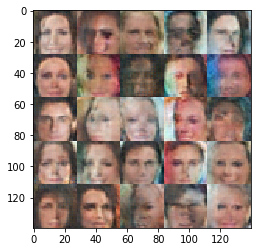

Epoch 1/1... Discriminator Loss: 1.0735... Generator Loss: 1.9342
Epoch 1/1... Discriminator Loss: 0.7987... Generator Loss: 1.1846
Epoch 1/1... Discriminator Loss: 1.2444... Generator Loss: 0.9299
Epoch 1/1... Discriminator Loss: 0.4681... Generator Loss: 2.2103
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.5930
Epoch 1/1... Discriminator Loss: 0.3889... Generator Loss: 3.7672
Epoch 1/1... Discriminator Loss: 0.5202... Generator Loss: 1.9091


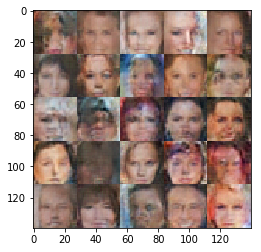

Epoch 1/1... Discriminator Loss: 0.3532... Generator Loss: 4.6626
Epoch 1/1... Discriminator Loss: 0.3454... Generator Loss: 5.3271
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 1.7187
Epoch 1/1... Discriminator Loss: 0.3522... Generator Loss: 4.9700
Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 0.9909... Generator Loss: 0.8432


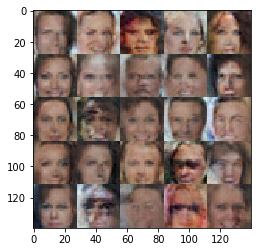

Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 1.8091
Epoch 1/1... Discriminator Loss: 1.4791... Generator Loss: 0.4936
Epoch 1/1... Discriminator Loss: 0.6473... Generator Loss: 2.0926
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.5429
Epoch 1/1... Discriminator Loss: 0.5338... Generator Loss: 1.9860
Epoch 1/1... Discriminator Loss: 0.3931... Generator Loss: 3.3353
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 0.7645


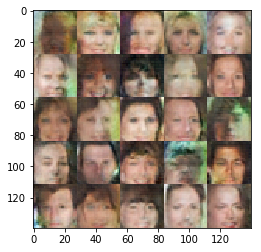

Epoch 1/1... Discriminator Loss: 1.7613... Generator Loss: 0.3769
Epoch 1/1... Discriminator Loss: 0.9962... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 0.8237... Generator Loss: 1.0460
Epoch 1/1... Discriminator Loss: 0.3655... Generator Loss: 3.7721
Epoch 1/1... Discriminator Loss: 0.7177... Generator Loss: 2.1680
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.4946
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 1.6585


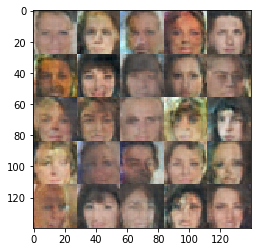

Epoch 1/1... Discriminator Loss: 0.4117... Generator Loss: 2.7652
Epoch 1/1... Discriminator Loss: 0.6200... Generator Loss: 1.6652
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.4921
Epoch 1/1... Discriminator Loss: 0.4968... Generator Loss: 3.1182
Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 0.4787
Epoch 1/1... Discriminator Loss: 2.0151... Generator Loss: 0.2739


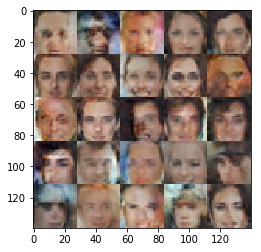

Epoch 1/1... Discriminator Loss: 0.3867... Generator Loss: 3.1135
Epoch 1/1... Discriminator Loss: 1.0907... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.2461... Generator Loss: 0.5443
Epoch 1/1... Discriminator Loss: 0.3833... Generator Loss: 3.2786
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 0.3519... Generator Loss: 4.2365
Epoch 1/1... Discriminator Loss: 1.0488... Generator Loss: 0.7579


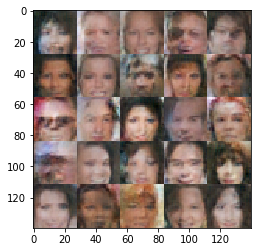

Epoch 1/1... Discriminator Loss: 0.8376... Generator Loss: 1.0156
Epoch 1/1... Discriminator Loss: 1.8056... Generator Loss: 0.3482
Epoch 1/1... Discriminator Loss: 0.6024... Generator Loss: 2.3231
Epoch 1/1... Discriminator Loss: 0.5225... Generator Loss: 1.9884
Epoch 1/1... Discriminator Loss: 0.8276... Generator Loss: 4.4053
Epoch 1/1... Discriminator Loss: 0.9666... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.6549


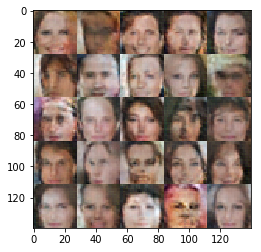

Epoch 1/1... Discriminator Loss: 1.8784... Generator Loss: 0.2973
Epoch 1/1... Discriminator Loss: 0.5293... Generator Loss: 1.8323


In [16]:
batch_size = 16
z_dim = 256
learning_rate = 0.0002
beta1 = 0.1
print_every = 30
show_every = 200
n_images = 25


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.